# Deep Learning Term Project for ECG (DIL700)

# Iteration 5

## Imports

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
##### %matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [20]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Removing class 3 and renaming class 4 to class 3

In [21]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df.loc[train_df[187] == 4, 187] = 3
test_df.loc[test_df[187] == 4, 187] = 3
full_df.loc[full_df[187] == 4, 187] = 3


In [22]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [23]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [24]:
print(train_df[187].unique())

[0. 1. 2. 3.]


In [25]:
labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Paced']
labels_short =  ["N","S","V","Q"]

In [26]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
print(labels[2],':', len(train_df[train_df[187]==2]))
print(labels[3],':', len(train_df[train_df[187]==3]))

Number of samples in data:
Normal : 72471
Artial Premature : 2223
Premature ventricular contraction : 5788
Paced : 6431


In [27]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
print(labels[2],':', len(test_df[test_df[187]==2]))
print(labels[3],':', len(test_df[test_df[187]==3]))

Number of samples in data:
Normal : 18118
Artial Premature : 556
Premature ventricular contraction : 1448
Paced : 1608


## Preparation

In [28]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

y_train_nn = pd.get_dummies(y_train, columns=[1])
y_train_nn = y_train_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

y_valid_nn = pd.get_dummies(y_valid, columns=[1])
y_valid_nn = y_valid_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]
y_test_nn = pd.get_dummies(y_test, columns=[1])
y_test_nn = y_test_nn.rename(columns={0: "N", 1: "S", 2: "V", 3: "Q"})

In [29]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
28367,0.989610,0.888312,0.425974,0.049351,0.096104,0.124675,0.101299,0.093506,0.096104,0.090909,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62622,1.000000,0.954751,0.266968,0.000000,0.063348,0.099548,0.104072,0.176471,0.153846,0.126697,...,0.298643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3227,1.000000,0.942431,0.686567,0.422175,0.321962,0.268657,0.179104,0.138593,0.149254,0.147122,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57171,1.000000,0.875831,0.170732,0.000000,0.106430,0.137472,0.128603,0.119734,0.113082,0.099778,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69122,1.000000,0.773333,0.053333,0.073333,0.090000,0.093333,0.086667,0.093333,0.083333,0.086667,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
y_train

28367    0.0
62622    0.0
3227     0.0
57171    0.0
69122    0.0
        ... 
38510    0.0
19805    0.0
41091    0.0
4546     0.0
77955    2.0
Name: 187, Length: 69530, dtype: float64

In [31]:
y_train_nn

,N,S,V,Q
28367,1,0,0,0
62622,1,0,0,0
3227,1,0,0,0
57171,1,0,0,0
69122,1,0,0,0
...,...,...,...,...
38510,1,0,0,0
19805,1,0,0,0
41091,1,0,0,0
4546,1,0,0,0


In [32]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
14772,0.964912,0.912281,0.583960,0.273183,0.147870,0.120301,0.092732,0.060150,0.050125,0.030075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49137,0.987080,0.953488,0.731266,0.253230,0.069767,0.139535,0.103359,0.038760,0.012920,0.025840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31361,0.000000,0.294118,0.745098,0.281046,0.117647,0.372549,0.588235,0.575163,0.633987,0.620915,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60850,0.817021,0.646809,0.178723,0.051064,0.085106,0.136170,0.131915,0.229787,0.234043,0.136170,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64495,1.000000,0.890966,0.520249,0.261682,0.168224,0.161994,0.118380,0.099688,0.074766,0.087227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45252,0.993661,0.801902,0.193344,0.000000,0.215531,0.213946,0.221870,0.231379,0.231379,0.225040,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61241,1.000000,0.789256,0.107438,0.012397,0.097107,0.088843,0.070248,0.057851,0.047521,0.051653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30540,1.000000,0.695946,0.087838,0.020270,0.077703,0.094595,0.097973,0.091216,0.091216,0.087838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86618,1.000000,0.854054,0.578378,0.370270,0.275676,0.300000,0.291892,0.308108,0.297297,0.305405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dataset Distribution

### Training set

In [33]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    72471
1     2223
2     5788
3     6431
Name: 187, dtype: int64


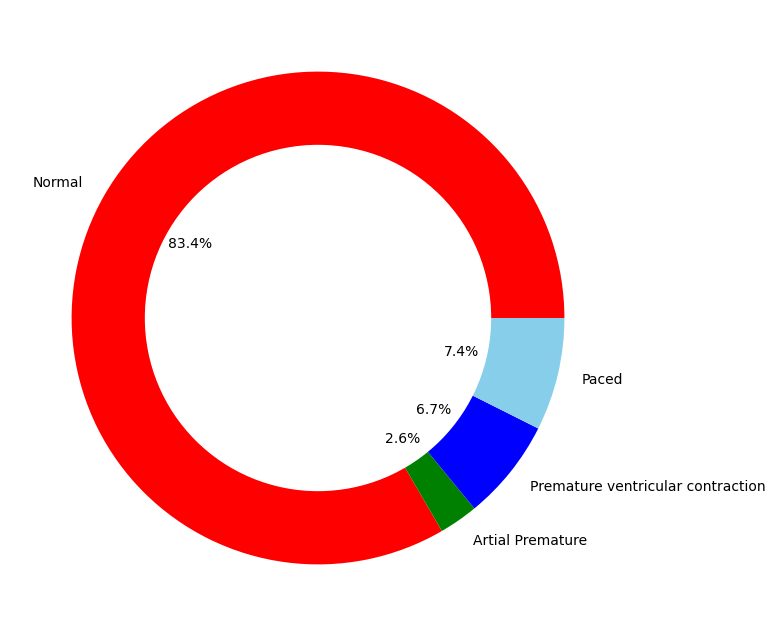

In [34]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [35]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1      556
2     1448
3     1608
Name: 187, dtype: int64


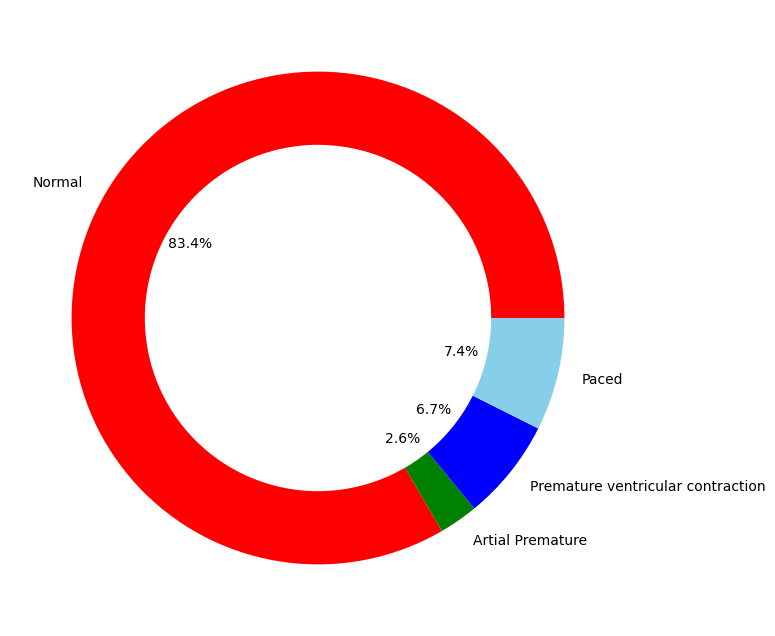

In [36]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# LSTM

The 0's in the end of the columsn seem to be the cause of the model not learning correctly

In [37]:
X_train_short = X_train.iloc[:, : 50]
X_valid_short = X_valid.iloc[:, : 50]
X_train_short

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
28367,0.989610,0.888312,0.425974,0.049351,0.096104,0.124675,0.101299,0.093506,0.096104,0.090909,...,0.189610,0.168831,0.161039,0.150649,0.142857,0.137662,0.127273,0.132468,0.135065,0.137662
62622,1.000000,0.954751,0.266968,0.000000,0.063348,0.099548,0.104072,0.176471,0.153846,0.126697,...,0.520362,0.470588,0.447964,0.429864,0.393665,0.366516,0.366516,0.361991,0.334842,0.330317
3227,1.000000,0.942431,0.686567,0.422175,0.321962,0.268657,0.179104,0.138593,0.149254,0.147122,...,0.211087,0.215352,0.211087,0.215352,0.219616,0.217484,0.206823,0.211087,0.215352,0.215352
57171,1.000000,0.875831,0.170732,0.000000,0.106430,0.137472,0.128603,0.119734,0.113082,0.099778,...,0.206208,0.181818,0.184035,0.172949,0.175166,0.164080,0.170732,0.168514,0.177384,0.170732
69122,1.000000,0.773333,0.053333,0.073333,0.090000,0.093333,0.086667,0.093333,0.083333,0.086667,...,0.183333,0.183333,0.176667,0.193333,0.183333,0.183333,0.186667,0.176667,0.180000,0.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.059663,0.060960,0.070039,0.072633,0.063554,0.071336,0.077821,0.075227,0.070039,0.073930
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.264925,0.236940,0.227612,0.214552,0.195896,0.184701,0.177239,0.173507,0.188433,0.158582
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.281081,0.259459,0.289189,0.267568,0.281081,0.262162,0.254054,0.200000,0.205405,0.178378
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.176259,0.208633,0.179856,0.197842,0.179856,0.183453,0.179856,0.194245,0.183453,0.194245


In [38]:
name = 'lstm_test_2'

In [40]:
X_train_short = X_train.iloc[:, : 50]
X_valid_short = X_valid.iloc[:, : 50]
X_train_short

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
28367,0.989610,0.888312,0.425974,0.049351,0.096104,0.124675,0.101299,0.093506,0.096104,0.090909,...,0.189610,0.168831,0.161039,0.150649,0.142857,0.137662,0.127273,0.132468,0.135065,0.137662
62622,1.000000,0.954751,0.266968,0.000000,0.063348,0.099548,0.104072,0.176471,0.153846,0.126697,...,0.520362,0.470588,0.447964,0.429864,0.393665,0.366516,0.366516,0.361991,0.334842,0.330317
3227,1.000000,0.942431,0.686567,0.422175,0.321962,0.268657,0.179104,0.138593,0.149254,0.147122,...,0.211087,0.215352,0.211087,0.215352,0.219616,0.217484,0.206823,0.211087,0.215352,0.215352
57171,1.000000,0.875831,0.170732,0.000000,0.106430,0.137472,0.128603,0.119734,0.113082,0.099778,...,0.206208,0.181818,0.184035,0.172949,0.175166,0.164080,0.170732,0.168514,0.177384,0.170732
69122,1.000000,0.773333,0.053333,0.073333,0.090000,0.093333,0.086667,0.093333,0.083333,0.086667,...,0.183333,0.183333,0.176667,0.193333,0.183333,0.183333,0.186667,0.176667,0.180000,0.180000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.059663,0.060960,0.070039,0.072633,0.063554,0.071336,0.077821,0.075227,0.070039,0.073930
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.264925,0.236940,0.227612,0.214552,0.195896,0.184701,0.177239,0.173507,0.188433,0.158582
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.281081,0.259459,0.289189,0.267568,0.281081,0.262162,0.254054,0.200000,0.205405,0.178378
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.176259,0.208633,0.179856,0.197842,0.179856,0.183453,0.179856,0.194245,0.183453,0.194245


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential()

# Add the LSTM layers
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_short.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))

# Add the output layer
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# Train the model
history = model.fit(X_train_short, y_train_nn, epochs=100, callbacks=callbacks, batch_size=32, validation_data=(X_valid_short, y_valid_nn))

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
2173/2173 [==============================] - 128s 57ms/step - loss: 0.1751 - accuracy: 0.8915 - val_loss: 0.1475 - val_accuracy: 0.9158
Epoch 2/100
2173/2173 [==============================] - 122s 56ms/step - loss: 0.1144 - accuracy: 0.9318 - val_loss: 0.0942 - val_accuracy: 0.9462
Epoch 3/100
2173/2173 [==============================] - 125s 57ms/step - loss: 0.0947 - accuracy: 0.9444 - val_loss: 0.0804 - val_accuracy: 0.9520
Epoch 4/100
2173/2173 [==============================] - 122s 56ms/step - loss: 0.0791 - accuracy: 0.9548 - val_loss: 0.0738 - val_accuracy: 0.9564
Epoch 5/100
2173/2173 [==============================] - 130s 60ms/step - loss: 0.0708 - accuracy: 0.9587 - val_loss: 0.0739 - val_accuracy: 0.9554
Epoch 6/100
2173/2173 [==============================] - 130s 60ms/step - loss: 0.0643 - accuracy: 0.9624 - val_loss: 0.0629 - val_accuracy: 0.9643
Epoch 7/100
2173/2173 [==============================] - 130s 60ms/step - loss: 0.0594 - accuracy: 0.9651 - val_

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

In [ ]:
X_test_short = X_test.iloc[:, : 50]

In [ ]:
# Predict test set labels
y_pred_cnn_proba = model.predict(X_test, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn_proba , axis=1)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred_cnn):.5f}')

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure()
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix CNN')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))